Ej. 4) Idem al problema anterior pero ahora que la función de costo sea Categorical Cross-Entropy.\
Esta función de costo puede verse, al igual que para el clasificador lineal SoftMax, como\
aplicar la función softmax seguido de la log-likelihood. Modificar el código anterior para\
que se pueda cambiar la métrica a utilizar (loss_mse o loss_softmax) y lo mismo para el\
cálculo del gradiente (grad_mse o grad_softmax). Analizar los resultados respecto a los\
clasificadores lineales SVM y Softamx como también con la resolución del punto anterior.\
Armar un gráfico aparte para mostrar la precisión de estos cuatro métodos todos juntos\
(sólo para los datos de testing)

Ej. 5) Idem al problema anterior pero esta vez que las funciones de activación de la capa oculta\
sean ReLU y las de la capa de salida sean sigmoidal. Al igual que en los problemas anteriores\
armar el grafo, calcular los gradientes, graficar la evolución de la precisión (accuracy) y las\
funciones de costo (mse y categorical cross-entropy) para las distintas épocas tanto para los\
datos de validación como entrenamiento. Discuta que métrica es mejor y porque. Además\
analizar qué pasa si usamos una ReLU + activación lineal en la última capa. Explicar y\
fundamentar si usar una activación lineal en la última capa es mejor o no.

In [1]:
import numpy as np
from scipy import linalg
from scipy.special import expit
from matplotlib import pyplot as plt
from keras.datasets import cifar10

In [2]:
names_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 
              3: 'cat', 4: 'deer', 5: 'dog', 
              6: 'frog', 7: 'horse', 8: 'ship', 
              9: 'truck'}

In [3]:
def clean(X):
        X_norm = X.reshape(len(X), X[0].size).astype(float)
        X_norm -= np.mean(X)
        X_norm /= np.std(X).astype(float)
        return X_norm

In [4]:
def sigmoid(z):
    return expit(z)

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def RELU(z):
    return np.maximum(0, z)

def RELU_prime(z):
    return 1*(RELU(z).astype(bool))

def lineal(z):
    return z

def lineal_prime(z):
    return 1

In [5]:
def softmax_fun(z):
    z -= 0.5*z.max()
    
    return np.exp(z)*(1.0/np.sum(np.exp(z), axis=0))

def CCE(yb_pred, yb):
    """Función de Categorical Cross Entropy"""
    m = yb_pred.shape[0]
    idx = np.arange(m)
    
    #cost = -np.sum(np.log(yb_pred[idx, yb]))/m
    SM = softmax_fun(yb_pred)

    #A ver si funciona esta maña
    reg = np.where(SM > 1e-10, SM, 1e-10)
    
    cost = np.sum(-np.log(reg[idx, yb]))/m

    return cost

def grad_CCE(yb_pred, yb):
    m = yb_pred.shape[0]
    idx = np.arange(m)
    SM = softmax_fun(yb_pred)
    SM[idx, yb] -= 1

    return SM/m

In [6]:
prob = np.random.randint(5, size=4) /4
np.where(prob > 1e-10, prob, 1e-10)

array([1.0e-10, 2.5e-01, 2.5e-01, 5.0e-01])

In [7]:
def accuracy(ypred, ytrue):
    ypred_idx = np.argmax(ypred, axis=1)

    return np.mean(ypred_idx==ytrue)

In [8]:
def MSE(yb_pred, yb):
    diff = np.copy(yb_pred)
    m = yb_pred.shape[0]
    idx = np.arange(0, m)
    diff[idx, yb] -= 1

    return (linalg.norm(diff)**2 / (2*m))

def grad_MSE(yb_pred, yb):
    diff = np.copy(yb_pred)
    m = yb_pred.shape[0]
    idx = np.arange(0, m)
    diff[idx, yb] -= 1
    
    return diff/m

![backprop](img/backprop.png)

In [9]:
def fit(Xtrain, ytrain, Xtest, ytest, batch_size, metric=MSE, layer1=sigmoid, 
        layer2=lineal, epochs=10, alpha=.001, lambda_= .001):
    
    #Calculo tamaño del batch
    #Inicializo variables etc
    m = Xtrain.shape[0]
    n = Xtrain.shape[1]
    n_batches = int(m/batch_size)


    grad_metric = "grad_"+str(metric.__name__)
    layer1_prime = str(layer1.__name__)+"_prime"
    layer2_prime = str(layer2.__name__)+"_prime"

    Xtrain = np.hstack((np.ones((m, 1)), Xtrain))
    Xtest = np.hstack((np.ones((Xtest.shape[0], 1)), Xtest))

    Xb = np.zeros((batch_size, n), dtype=float)
    Xb = np.hstack((np.ones((batch_size, 1)), Xb))
    yb = np.zeros((batch_size), dtype=float)
    W1 = np.random.uniform(-1e-2, 1e-2, size=(n+1, 100))
    W2 = np.random.uniform(-1e-2, 1e-2, size=(101, 10))

    loss_train = []
    loss_test = []
    acc_test = []

    for epoch in range(epochs):
        #Shuffle indice datos de training
        shuffle = np.random.permutation(m)

        Xtrain = Xtrain[shuffle]
        ytrain = ytrain[shuffle]
        loss=0
        #Calculo terminos de regularizacion
        L2 = linalg.norm(W1)**2 + linalg.norm(W2)**2

        for batch in range(n_batches):
            Xb = Xtrain[batch*batch_size : (batch+1)*batch_size, :]
            yb = ytrain[batch*batch_size : (batch+1)*batch_size]
            
            #Forward todo mi batch
            z1 = layer1(np.dot(Xb, W1))
            z1 = np.hstack((np.ones((batch_size, 1)), z1))
            z2 = np.dot(z1, W2)
            yb_pred = layer2(z2)

            #Calculo loss con la metrica elegida
            loss += metric(yb_pred, yb) + (lambda_/2) * L2

            #Calculo grads:
            #grad de la funcion de loss
            grad = globals()[grad_metric](yb_pred, yb)

            #Layer 2
            grad = grad * globals()[layer2_prime](z2)
            gradW2 = np.dot(z1.T, grad) #S1 tiene la columna de unos
            grad = np.dot(grad, W2.T)
            grad = grad[:, 1:]  

            #Layer 1
            grad_sig = globals()[layer1_prime](np.dot(Xb, W1))
            grad = grad * grad_sig  #Producto elemento a elemento
            gradW1 = np.dot(Xb.T, grad) #Xb incluye columna de 1s
            
            W1 -= alpha*(gradW1 + lambda_ * W1)
            W2 -= alpha*(gradW2 + lambda_ * W2)
        
        #Calculo loss y accuracy
        loss_train.append(loss/n_batches)
        
        z1t = layer1(np.dot(Xtest, W1))
        z1t = np.hstack((np.ones((Xtest.shape[0], 1)), z1t))
        ybt_pred = layer2(np.dot(z1t, W2))
        loss_test.append(metric(ybt_pred, ytest) + (lambda_/2) * L2)
        acc_test.append(accuracy(ybt_pred, ytest))
        
        if epoch%10 == 0:
            print("Train loss of epoch {}: {:.6f}, Test accuracy: {:.2f}%".format(epoch, loss_train[-1], 100*acc_test[-1]))
    return loss_train, loss_test, acc_test




In [10]:
(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()

ytrain = ytrain[:,0]
ytest = ytest[:,0]

Xtrain = clean(Xtrain)
Xtest = clean(Xtest)
# summarize loaded dataset
print('Train: X=%s, y=%s' % (Xtrain.shape, ytrain.shape))
print('Test: X=%s, y=%s' % (Xtest.shape, ytest.shape))

Train: X=(50000, 3072), y=(50000,)
Test: X=(10000, 3072), y=(10000,)


In [11]:
#Ej 3
(loss_train_3, loss_test_3, acc_test_3) = fit(Xtrain, ytrain, Xtest, ytest, batch_size=50, 
                                              metric=MSE, layer1=sigmoid, layer2=lineal, 
                                              epochs=200, alpha=1e-3, lambda_=.01)

Train loss of epoch 0: 0.499088, Test accuracy: 21.56%
Train loss of epoch 10: 0.456252, Test accuracy: 32.81%
Train loss of epoch 20: 0.442706, Test accuracy: 36.41%
Train loss of epoch 30: 0.433169, Test accuracy: 37.55%
Train loss of epoch 40: 0.426014, Test accuracy: 38.85%
Train loss of epoch 50: 0.420392, Test accuracy: 39.01%
Train loss of epoch 60: 0.415887, Test accuracy: 39.59%
Train loss of epoch 70: 0.412167, Test accuracy: 39.80%
Train loss of epoch 80: 0.409144, Test accuracy: 40.14%
Train loss of epoch 90: 0.406612, Test accuracy: 40.24%
Train loss of epoch 100: 0.404538, Test accuracy: 40.50%
Train loss of epoch 110: 0.402812, Test accuracy: 40.61%
Train loss of epoch 120: 0.401380, Test accuracy: 40.67%
Train loss of epoch 130: 0.400185, Test accuracy: 41.12%
Train loss of epoch 140: 0.399182, Test accuracy: 40.91%
Train loss of epoch 150: 0.398358, Test accuracy: 41.23%
Train loss of epoch 160: 0.397646, Test accuracy: 41.09%
Train loss of epoch 170: 0.397053, Test ac

In [13]:
#Ej 4
(loss_train_4, loss_test_4, acc_test_4) = fit(Xtrain, ytrain, Xtest, ytest, batch_size=50, 
                                              metric=CCE, layer1=lineal, layer2=lineal, 
                                              epochs=200, alpha=1e-3, lambda_=.01)

: 

: 

In [15]:
#Ej 5a (Voy a usar solo metrica MSE)
(loss_train_5a, loss_test_5a, acc_test_5a) = fit(Xtrain, ytrain, Xtest, ytest, batch_size=50, 
                                              metric=MSE, layer1=RELU, layer2=sigmoid, 
                                              epochs=200, alpha=1e-3, lambda_=.01)

Train loss of epoch 0: 0.994202, Test accuracy: 19.19%
Train loss of epoch 10: 0.498847, Test accuracy: 26.38%
Train loss of epoch 20: 0.472620, Test accuracy: 30.03%
Train loss of epoch 30: 0.455761, Test accuracy: 33.30%
Train loss of epoch 40: 0.443550, Test accuracy: 35.35%
Train loss of epoch 50: 0.434659, Test accuracy: 36.67%
Train loss of epoch 60: 0.427674, Test accuracy: 38.01%
Train loss of epoch 70: 0.421987, Test accuracy: 38.84%
Train loss of epoch 80: 0.417330, Test accuracy: 39.61%
Train loss of epoch 90: 0.413518, Test accuracy: 40.36%
Train loss of epoch 100: 0.410380, Test accuracy: 41.10%
Train loss of epoch 110: 0.407795, Test accuracy: 41.59%
Train loss of epoch 120: 0.405655, Test accuracy: 42.19%
Train loss of epoch 130: 0.403896, Test accuracy: 42.56%
Train loss of epoch 140: 0.402419, Test accuracy: 42.80%
Train loss of epoch 150: 0.401182, Test accuracy: 43.02%
Train loss of epoch 160: 0.400140, Test accuracy: 43.39%
Train loss of epoch 170: 0.399246, Test ac

In [16]:
#Ej 5b (Voy a usar solo metrica MSE)
(loss_train_5b, loss_test_5b, acc_test_5b) = fit(Xtrain, ytrain, Xtest, ytest, batch_size=50, 
                                              metric=MSE, layer1=RELU, layer2=lineal, 
                                              epochs=200, alpha=1e-3, lambda_=.01)

Train loss of epoch 0: 0.496641, Test accuracy: 27.55%
Train loss of epoch 10: 0.418433, Test accuracy: 42.16%
Train loss of epoch 20: 0.397802, Test accuracy: 45.36%
Train loss of epoch 30: 0.384229, Test accuracy: 47.06%
Train loss of epoch 40: 0.373945, Test accuracy: 48.41%
Train loss of epoch 50: 0.366048, Test accuracy: 48.89%
Train loss of epoch 60: 0.359737, Test accuracy: 49.48%
Train loss of epoch 70: 0.354665, Test accuracy: 49.84%
Train loss of epoch 80: 0.350547, Test accuracy: 50.16%
Train loss of epoch 90: 0.347191, Test accuracy: 50.23%
Train loss of epoch 100: 0.344428, Test accuracy: 50.55%
Train loss of epoch 110: 0.342116, Test accuracy: 50.49%
Train loss of epoch 120: 0.340171, Test accuracy: 50.47%
Train loss of epoch 130: 0.338584, Test accuracy: 50.87%
Train loss of epoch 140: 0.337235, Test accuracy: 50.76%
Train loss of epoch 150: 0.336070, Test accuracy: 51.13%
Train loss of epoch 160: 0.335109, Test accuracy: 51.46%
Train loss of epoch 170: 0.334264, Test ac

0.4169

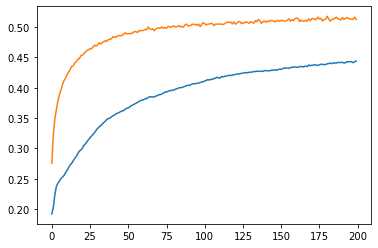

In [18]:
plt.plot(acc_test_5a);
plt.plot(acc_test_5b)
acc_test_3[-1]

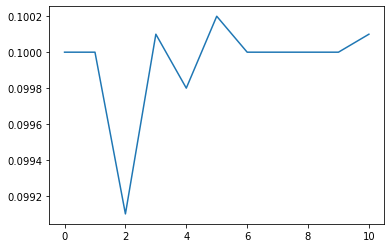

In [ ]:
plt.plot(acc_test_3)